In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

np.random.seed(0)
random.seed(0)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

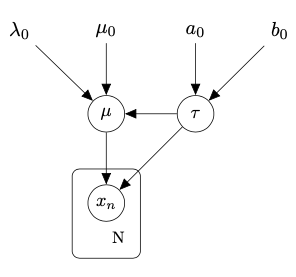

### ***Question 1.3.9:***

Implement a function that generates data points for the given model.

In [12]:
def generate_data(mu, tau, N):
    # generate N normal data points with mean mu and var 1/tau
    D = np.random.normal(loc=mu, scale=1/np.sqrt(tau), size=N)
    return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



In [ ]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
plt.figure(1)
plt.hist(dataset_1)
plt.title("Dataset 1 (N=10)")
plt.savefig("dataset_1_hist.png", dpi=300)

plt.figure(2)
plt.hist(dataset_2)
plt.title("Dataset 2 (N=100)")
plt.savefig("dataset_2_hist.png", dpi=300)

plt.figure(3)
plt.hist(dataset_3)
plt.title("Dataset 3 (N=1000)")
plt.savefig("dataset_3_hist.png", dpi=300)

# show figures
plt.show()

### ***Question 1.3.10:***

Find ML estimates of the variables μ and τ

In [13]:
def ML_est(data):
    mu_ml = np.mean(data)
    tau_ml = 1/np.var(data)
    return mu_ml, tau_ml

In [ ]:
print(ML_est(dataset_1))
print(ML_est(dataset_2))
print(ML_est(dataset_3))

### ***Question 1.3.11:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [54]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    N = len(D)
    a_N = a_0 + N/2
    b_N = b_0 + 1/2*(N*np.var(D) + lambda_0*N/(lambda_0 + N)*(np.mean(D) - mu_0)**2)
    mu_N = (lambda_0*mu_0 + N*np.mean(D))/(lambda_0 + N)
    lambda_N = lambda_0 + N/2
    exact_post_dist_parameters = (a_N, b_N, mu_N, lambda_N)

    return exact_post_dist_parameters

### ***Question 1.3.12:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [15]:
# prior parameters
mu_0 = 1.0
lambda_0 = 0.1
a_0 = 1.0
b_0 = 2.0

Continue with a helper function that computes ELBO:


In [16]:
import numpy as np
from scipy.stats import gamma, norm
from scipy.special import digamma, gammaln

def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N, b_N, mu_N, lambda_N):
    N = len(D)
    
    E_tau = a_N / b_N
    E_log_tau = digamma(a_N) - np.log(b_N)
    
    v_N = 1.0 / (lambda_N * E_tau)
    
    E_xmu2 = (D - mu_N) ** 2 + v_N
    
    E_mumu0_2 = (mu_N - mu_0) ** 2 + v_N
    
    const_normal = -0.5 * np.log(2 * np.pi)
    
    E_log_p_x = np.sum(0.5 * E_log_tau + const_normal - 0.5 * E_tau * E_xmu2)
    
    E_log_p_mu = (0.5 * np.log(lambda_0)+ 0.5 * E_log_tau + const_normal - 0.5 * lambda_0 * E_tau * E_mumu0_2)
    
    E_log_p_tau = (a_0 * np.log(b_0) - gammaln(a_0) + (a_0 - 1) * E_log_tau - b_0 * E_tau)
    
    E_log_q_mu = -0.5 * (np.log(2 * np.pi * v_N) + 1.0)
    
    E_log_q_tau = (a_N * np.log(b_N) - gammaln(a_N) + (a_N - 1) * E_log_tau - b_N * E_tau)
    
    elbo = E_log_p_x + E_log_p_mu + E_log_p_tau - E_log_q_mu - E_log_q_tau
    return elbo


Now, implement the CAVI algorithm:

In [61]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
    # make an initial guess for the expected value of tau
    initial_guess_exp_tau = a_0 / b_0
    MAX_ITER = 1000
    step_size = 0.01
    tol = 1e-6

    #inititalize
    a_N = a_0
    b_N = b_0
    mu_N = mu_0
    lambda_N = lambda_0

    a_N_out = [a_N]
    b_N_out = [b_N]
    mu_N_out = [mu_N]
    lambda_N__out = [lambda_N]

    elbo_after_init = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)
    # Store output per iteration
    elbos = [elbo_after_init]
    
    # CAVI iterations ...
    for i in range(MAX_ITER):
        mu_star, lambda_star = update_q_mu(a_N, b_N, mu_0, lambda_0, D)
        mu_N += step_size * ( mu_star - mu_N)
        lambda_N += step_size * (lambda_star - lambda_N)

        a_star, b_star = update_q_tau(a_0, b_0, D, mu_N, lambda_N, mu_0, lambda_0) 
        a_N += step_size * (a_star - a_N)
        b_N += step_size * (b_star - b_N)
        elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

        a_N_out.append(a_N)
        b_N_out.append(b_N)
        mu_N_out.append(mu_N)
        lambda_N__out.append(lambda_N)

        if i > 1 and np.abs(elbos[i] - elbos[i-1]) < tol:
            break
        # save ELBO for each iteration, plot them afterwards to show convergence


    return a_N, b_N, mu_N, lambda_N, elbos

In [19]:
def update_q_mu(a_n, b_n, mu_0, lambda_0, D):
    
    N = len(D)
    
    lambda_star = (lambda_0 + N)*(a_n/b_n)
    
    mu_star = (lambda_0*mu_0 + N*np.mean(D))/(lambda_0 + N)

    return mu_star, lambda_star



def update_q_tau(a_0, b_0, D, mu_n, lambda_n,mu_0, lambda_0):
    
    N = len(D)
    
    a_star = a_0 + (N+1)/2
    
    E_xn_mun = np.sum((D-mu_n)**2 + 1.0/(lambda_n))
    
    E_mu0_mun = (mu_n-mu_0)**2 + 1.0/(lambda_n)
    
    b_star = b_0 + 0.5*E_xn_mun + (lambda_0/2)*E_mu0_mun

    return a_star, b_star

Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.


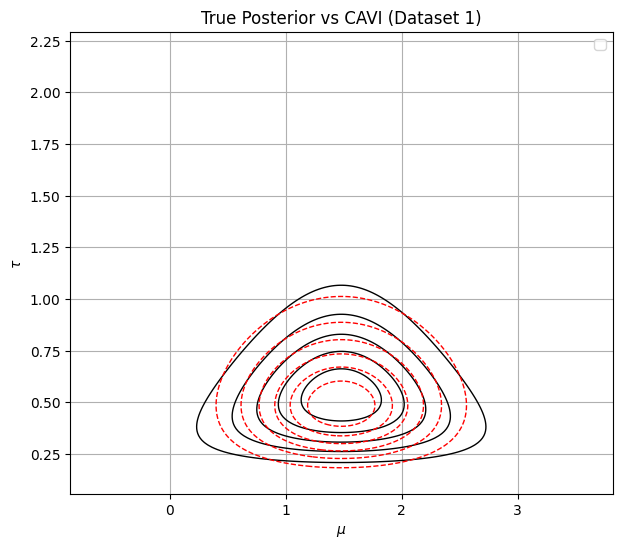

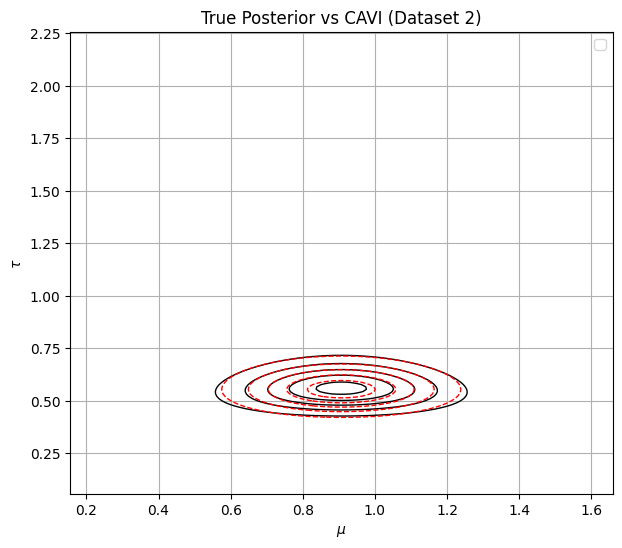

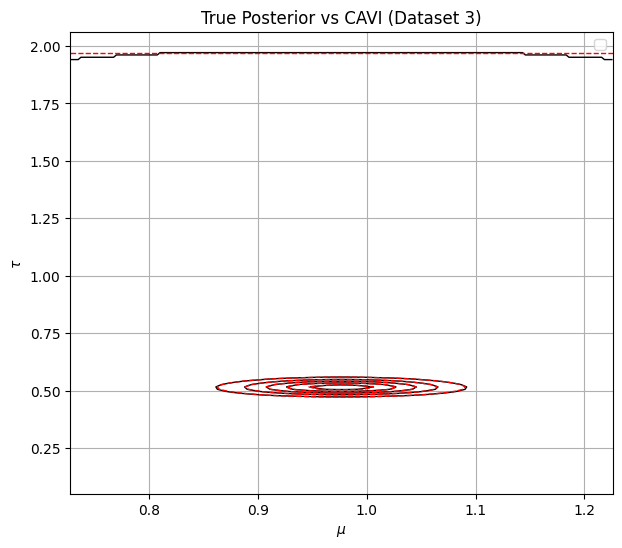

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# ---------------------------------------------------
# Plot true posterior vs CAVI for each dataset
# ---------------------------------------------------

for idx in range(3):

    # -------- unpack posterior and CAVI parameters --------
    a_true, b_true, mu_true, lambda_true = exact_posterior[idx]
    a_cavi, b_cavi, mu_cavi, lambda_cavi = cavi_params[idx]

    # expectations
    E_tau_true = a_true / b_true
    E_tau_cavi = a_cavi / b_cavi

    # variance of mu under q(mu)
    v_cavi = 1.0 / (lambda_cavi * E_tau_cavi)

    # define grid range for mu and tau
    mu_std = np.sqrt(1.0 / (lambda_true * E_tau_true))
    mu_vals = np.linspace(mu_true - 4 * mu_std,
                          mu_true + 4 * mu_std, 200)
    tau_vals = np.linspace(0.1 * E_tau_true,
                           4 * E_tau_true, 200)

    MU, TAU = np.meshgrid(mu_vals, tau_vals)

    # ------- compute true posterior density --------
    true_mu_var = 1.0 / (lambda_true * TAU)
    P_true = norm.pdf(MU, mu_true, np.sqrt(true_mu_var)) * gamma.pdf(
        TAU, a_true, scale=1.0 / b_true
    )

    # ------- compute CAVI approximate density -------
    P_cavi = norm.pdf(MU, mu_cavi, np.sqrt(v_cavi)) * gamma.pdf(
        TAU, a_cavi, scale=1.0 / b_cavi
    )

    # ------- plot -------
    plt.figure(figsize=(7, 6))
    plt.contour(MU, TAU, P_true, levels=6, colors="black", linewidths=1)
    plt.contour(MU, TAU, P_cavi, levels=6, colors="red", linestyles="--", linewidths=1)

    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\tau$")
    plt.title(f"True Posterior vs CAVI (Dataset {idx+1})")
    plt.legend(["True posterior", "CAVI approximation"])
    plt.grid(True)

    # save figure
    plt.savefig(f"posterior_compare_{idx+1}.png", dpi=200, bbox_inches="tight")

    plt.show()


In [67]:
    mu_vals = np.linspace(mu_N - 4*np.sqrt(1/(lambda_N*(a_N/b_N))),
                          mu_N + 4*np.sqrt(1/(lambda_N*(a_N/b_N))), 200)
    
    tau_vals = np.linspace((a_N/b_N)*0.1, (a_N/b_N)*4, 200)
    
    MU, TAU = np.meshgrid(mu_vals, tau_vals)
    
    # ===== True Posterior =====
    # p(mu | tau, x) * p(tau | x)
    true_mu_var = 1 / (lambda_N * TAU)
    P_true = norm.pdf(MU, mu_N, np.sqrt(true_mu_var)) * gamma.pdf(TAU, a_N, scale=1/b_N)
    
    # ===== CAVI Approximation =====
    # q(mu) q(tau)
    P_cavi = norm.pdf(MU, mu_cavi, np.sqrt(v_cavi)) * gamma.pdf(TAU, a_cavi, scale=1/b_cavi)
    
    # ===== Plot =====
    plt.figure(figsize=(7,6))
    
    # True posterior contours
    plt.contour(MU, TAU, P_true, levels=6, colors="black", linewidths=1)
    
    # CAVI approximation contours
    plt.contour(MU, TAU, P_cavi, levels=6, colors="red", linestyles="--", linewidths=1)
    
    # ML estimate as a point
    plt.scatter(mu_ml, tau_ml, color="blue", marker="x", s=80, label="ML estimate")
    
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$\tau$")
    plt.title(title)
    plt.legend(["True Posterior", "CAVI Approx.", "ML estimate"])
    plt.grid(True)
    plt.show()

NameError: name 'mu_cavi' is not defined